In [3]:
# read the path file with python
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
# import tensorflow as tf
# import tensorflow.keras as keras
import math
# from scipy.optimize import fsolve
# from scipy.optimize import root
from scipy.optimize import minimize
from scipy import signal
from scipy import linalg
import scipy as scipy
# import scipy as scp
# import sympy as  syp
# from tensorflow.keras import backend as K
# from tensorflow.keras.layers import Layer
# from tensorflow.keras.models import Sequential
import gc
import struct

In [46]:
class readpath(object):
    
    def __init__(self,N):
        self.N = N
        return None
    
    def generate_path(self):
        dict1 = {0:'C:\\Users\\Administrator\\source\\data\\path_kiwi_whole.dat',
                 1:'C:\\Users\\Administrator\\source\\data\\path_kiwi_noskinskin.dat'
                ,2:'C:\\Users\\Administrator\\source\\data\\path_kiwi_soft3.dat',3:'C:\\Users\\Administrator\\source\\data\\path090_3.dat'
                ,4:'C:\\Users\\Administrator\\source\\data\\path117_3.dat',5:'C:\\Users\\Administrator\\source\\data\\path138_3.dat'
                ,6:'C:\\Users\\Administrator\\source\\data\\path156_3.dat',7:'C:\\Users\\Administrator\\source\\data\\path175_3.dat'}
        self.dict1 = dict1
        return dict1
    
    def read0(self,i):
        q = 0
        with open(self.dict1[i], "rb") as file0:
            data1 = file0.read(4)
            I = struct.unpack("i", data1)[0]
            data1 = file0.read(4)
            J = struct.unpack("i", data1)[0]
            data1 = file0.read(4)
            K = struct.unpack("i", data1)[0]
            h = []
            for i in range(I):
                a = []
                for j in range(J):
                    l = []
                    while(1):
                        data1 = file0.read(4)
                        f = struct.unpack("4s",data1)[0]
                        if (f!=b'end\x00'):
                            f = struct.unpack("f",data1)[0]
                            l.append(f)
                        else:
                            break
                    
                        

                    a.append(l)
                h.append(a)
                
        return I, h
    
    def read1(self):
        self.generate_path()
        h = [None]*self.N
        I = np.zeros((self.N,))
        for i in range(0,self.N):
            I[i],h[i] = self.read0(i)
            
        self.h = h
        self.I = I
        return h,I
    


In [47]:
N = 2
s1 = readpath(N)
h,I = s1.read1()
print(I)

[5000. 5000.]


In [48]:
indexout = np.zeros((4000,N))
for n in range(N):
    j = 0
    for i in range(int(I[0])):
        if(len(h[n][i][0])!=0):
            if(max(h[n][i][0])>0.045):
                indexout[j+1,n] = i
                j = j+1
    indexout[0,n]=j
print(j)

174


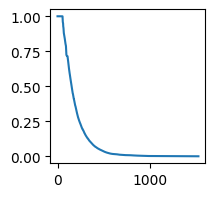

In [49]:
i=0
j = 3
plt.figure(figsize = (2,2))
plt.plot(h[i][int(indexout[j,i])][3])
plt.show()

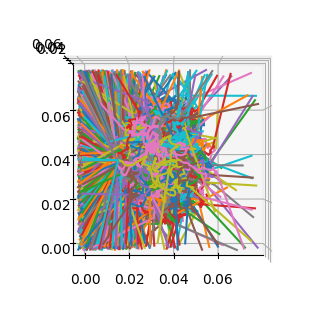

In [59]:
fig = plt.figure(figsize = (4,4))
ax = plt.axes(projection='3d')
h1 = h[0]
for i in range(int(I[0])): # int(I[0])
    # Data for a three-dimensional line
    xline = h1[i][0]
    yline = h1[i][1]
    zline = h1[i][2]
    ax.view_init(90,270) # (0,90) (45,225)
    ax.plot3D(xline, yline, zline)
    
plt.axis('on')
plt.show()

In [60]:
def analysis(h,I,indexout):
    eye = [0.046,0.0375,0.0375]
    #normal line vector (0.707,0.707,0)
    #euqation of surface : x+y=0.09
    N=480
    time = np.linspace(0, 4.8e-9, num=N)
    time_per_cell = 4.8e-9/N
    weight = np.zeros((N,))
    temp = pow(2,0.5)
    radius_fiber = 0.004
    threshold = 0.004
    for j in indexout[1:int(indexout[0])]:
        i=int(j)
        for k in range(len(h[i][0])):

            if((pow(h[i][0][k]-eye[0],2)+pow(h[i][1][k]-eye[1],2)
               +pow(h[i][2][k]-eye[2],2) < pow(radius_fiber,2)) and 
               ((h[i][0][k]-eye[0])<threshold)and((h[i][0][k]-eye[0])>0)):
                
                t = int(h[i][4][k]/time_per_cell)
                if(t<N):
                    weight[t]=weight[t]+h[i][3][k]
                else:
                    weight[0]=-114514
                break;

    return weight

def analysis_g(N, h, I,indexout):
    w2 = np.zeros((N,480))
    for i in range(0,N):
        w2[i] = analysis(h[i],I[i],indexout[:,i])

    return w2

In [61]:
w2 = analysis_g(N,h,I,indexout)

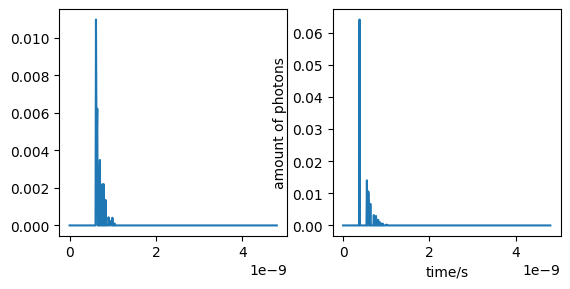

In [62]:
# plt.scatter(time,weight)
M=480
# N = 1
time = np.linspace(0, 4.8e-9, num=M)
# core = np.array([1,2,3,4,5,4,3,2,1])
# core = core/np.sum(core)
plt.figure(figsize = (10,10))
for i in range(N):
    plt.subplot(3,3,i+1)
    plt.plot(time,w2[i])
#     plt.plot(np.convolve(w2[i],core, mode = 'same'))
plt.xlabel('time/s')
plt.ylabel('amount of photons')
plt.show()

In [63]:
class process_hyperspec(object):
    
    def __init__(self, path, scat):
        self.path = path
        self.scat = scat
        
    def read_data(self):
        ## Read data from txt
        data=pd.read_fwf(self.path, dtype = object, header = None)## Read data as Pandas DataFrame
        data_8 = data.loc[8,:].str[6:] ## Select data of column of wavelengths

        data_nm_dataframe =pd.read_csv(StringIO(data_8[0]))

        with open(self.path,'r',encoding='utf-8') as f:
            content = f.read()

        flag = 0
        for index in range(len(content)):##find the start point  of time and intensity data, pointer is the 'index'
            if (content[index] == '\n') and (flag != 9):
                flag = flag + 1
            elif (content[index] == '\n') and (flag == 9):
                break
            else:
                continue

        data_ns = pd.read_csv(StringIO(content[index:len(content)]), names = data_nm_dataframe.columns[0:len(set(data_nm_dataframe))]) ## Read data of time and gray 
        img_nm_ns = np.array(data_ns)    ## Transform to numpy array                                image as DataFrame; names is a 640x0 array indicates the wavelengths range
        
        self.data_frame = data_ns
        self.data_array = img_nm_ns
        
    def cal_846nm(self):
        time_total, wavelength_total = self.data_array.shape ## Generate an array contains intensity versus time data on 846nm
        data_846nm = np.zeros((time_total,), dtype = float )
        for i in range(wavelength_total):
            data_846nm = self.data_array[:,i] + data_846nm

        return data_846nm/wavelength_total
    
    def return_dataframe(self):
        
        return self.data_frame
    
    def return_array(self):
        return self.data_array

In [64]:
dict0 = {0: '20230112\\kiwi01_irf.txt',1:'20230112\\kiwi01_whole.txt',2:'20230112\\kiwi01_noskinskin.txt',}


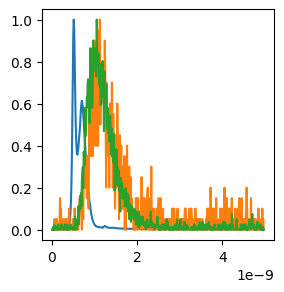

In [65]:
N1 = 3
scat = [None]*N1
data_480multi9 = np.zeros((N1,480), dtype = float)
for i in range(0,N1):
    scat[i] = process_hyperspec(dict0[i], i)
    scat[i].read_data()
    data_480multi9[i,:] = scat[i].cal_846nm()

time_index = scat[0].return_dataframe().index

line = [None]*N1
plt.figure(figsize = (3,3))
for i in range(0,N1):
    line[i], = plt.plot(time_index*1e-9,data_480multi9[i,:]/max(data_480multi9[i,:])) # /max(data_480multi9[i,:]

# plt.legend(handles=[line[0],line[1],line[2]]
#            ,labels=['whole IRF','soft whole','hard whole'],loc='best')
plt.show()
    

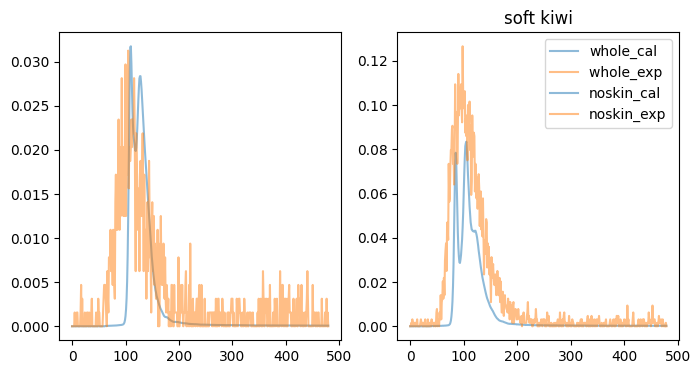

In [69]:
line = [None]*4
plt.figure(figsize = (8,4))
plt.subplot(1,2,1)
line[0], = plt.plot(np.convolve(data_480multi9[0,:], w2[0])[0:480]/60,alpha=0.5)
line[1], = plt.plot(data_480multi9[1,:],alpha=0.5)
plt.subplot(1,2,2)
line[2], = plt.plot(np.convolve(data_480multi9[0,:], w2[1])[0:480]/60,alpha=0.5)
line[3], = plt.plot(data_480multi9[2,:],alpha=0.5)
plt.title('soft kiwi')
plt.legend(handles=[line[0],line[1],line[2],line[3]]
           ,labels=['whole_cal','whole_exp ','noskin_cal','noskin_exp'],loc='best')


plt.show()

#